## 线性回归
* 线性回归是对n维输入的加权，外加偏差  
* 使用平方损失来衡量预测值和真实值的差异，最小化平方损失优化参数  
* 线性回归可以看做单层神经网络


## 基础优化算法
### 梯度下降
* 挑选一个初始值$ w_0 $    
* 重复迭代参数
 $$ w_t = w_{t-1} - \eta * \frac{\partial\tau}{\partial w_{t-1}} $$  
    * 沿梯度方向将增加损失函数值  
    * 学习率：步长的超参数

### 小批量随机梯度下降

* 可以随机采样b个样本$i_1,i_2...$来计算损失  
* b是批量大小，另一个重要的超参数

## 总结
* 梯度下降通过不断沿着反梯度反向更新参数求解  
* 小批量随机梯度下降是深度学习默认的求解算法
* 两个重要的超参数是批量大小和学习率


## 线性回归从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
test1 = torch.tensor([[1, 2],[3, 4], [5, 6]])
print(test1.shape)
test2 = torch.tensor([2,5])
print(test2.shape)
test3 = torch.matmul(test1, test2) 
print(test3)

torch.Size([3, 2])
torch.Size([2])
tensor([12, 26, 40])


In [3]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    print(X.shape)
    print(w.shape)
    y = torch.matmul(X, w) + b
    print(y.shape)
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1)) # 转化为一个列向量，行数由PyTorch确定

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features.shape, labels.shape)

torch.Size([1000, 2])
torch.Size([2])
torch.Size([1000])
torch.Size([1000, 2]) torch.Size([1000, 1])


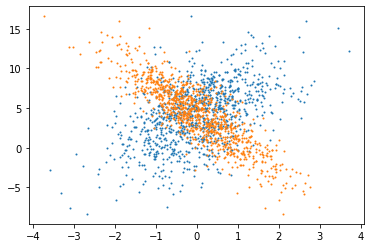

In [4]:
d2l.plt.scatter(features[:, 0].detach().numpy(),
               labels.detach().numpy(), 1);
d2l.plt.scatter(features[:, 1].detach().numpy(),
               labels.detach().numpy(), 1);

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本随机读取
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2837, -1.1415],
        [-1.7296,  1.2395],
        [-0.4072, -1.0657],
        [ 0.8068, -0.5739],
        [ 0.9350,  0.6294],
        [ 0.9261,  0.0469],
        [ 0.5887,  0.1209],
        [ 1.0453,  0.0800],
        [-0.2462, -1.0009],
        [-0.9834, -1.9801]]) 
 tensor([[ 8.6214],
        [-3.4714],
        [ 7.0171],
        [ 7.7414],
        [ 3.9347],
        [ 5.9025],
        [ 4.9878],
        [ 6.0245],
        [ 7.1194],
        [ 8.9537]])


### 定义初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型

In [7]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [8]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2  

### 定义优化算法

In [9]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
    

### 训练过程

In [10]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # `x`和`y`的小批量损失
        l = loss(net(X, w, b), y)
        # `l`的形状为(`batch_size`, 1)，需要求和计算梯度
        l.sum().backward()
        # 更新参数
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch +1 }, loss{float(train_l.mean()):f}')

epoch 1, loss0.037565
epoch 2, loss0.000131
epoch 3, loss0.000052
epoch 4, loss0.000052
epoch 5, loss0.000052


## 线性回归的简洁实现 

In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [5]:
# 调用框架中现有的API来读取数据
def load_array (data_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 使用iter构造Python迭代器，并使用next从迭代器中获取第一项
next(iter(data_iter))

[tensor([[-0.4107,  1.9892],
         [ 1.3561, -0.7755],
         [ 1.7004,  0.9903],
         [-0.0032, -0.9394],
         [-0.1631,  1.1513],
         [ 0.1327, -0.4551],
         [ 0.7742, -0.3475],
         [ 1.6557, -0.5504],
         [-0.7988,  0.3278],
         [ 1.3059, -0.7632]]),
 tensor([[-3.3856],
         [ 9.5573],
         [ 4.2293],
         [ 7.3921],
         [-0.0512],
         [ 6.0294],
         [ 6.9172],
         [ 9.3903],
         [ 1.4788],
         [ 9.3942]])]

### 使用框架预定义好的层

In [6]:
from torch import nn

# Sequential类为串联在一起的多个层定义了一个容器。
# 当给定输入数据，Sequential实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，依此类推。
net = nn.Sequential(nn.Linear(2, 1))

### 初始化模型参数

In [7]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [8]:
loss = nn.MSELoss()

### 实例化`SGD`实例

In [9]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
       
    l = loss(net(features), labels)
    print(f'epoch{epoch+1}, loss{l:f}')

tensor([[ 0.0012, -0.0108]])
epoch1, loss0.000103
tensor([[-0.0002, -0.0028]])
epoch2, loss0.000104
tensor([[0.0014, 0.0043]])
epoch3, loss0.000103
